# Testing the normflows package and augmenting it with Bayesian Methods

In [1]:
import torch
import numpy as np
import normflows as nf
import os

from matplotlib import pyplot as plt

from tqdm import tqdm

from jet_dataset import JetDataset

/beegfs/desy/user/bierings/conda/envs/bayesconda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
save_dir = './data/NF_jets15/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [4]:
###################################
### Define the Normalizing Flow ###
###################################

# Define flows
K = 4

latent_size = 1
hidden_units = 128
hidden_layers = 2
context_size = 16

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows)

# Move model on GPU if available
model = model.to(device)

In [8]:
#######################
### Define the data ###
#######################

batch_size = 16384

dataset = JetDataset("./jet_data",'train')
dataset_val = JetDataset("./jet_data",'val')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

100%|██████████| 10/10 [02:55<00:00, 17.60s/it]


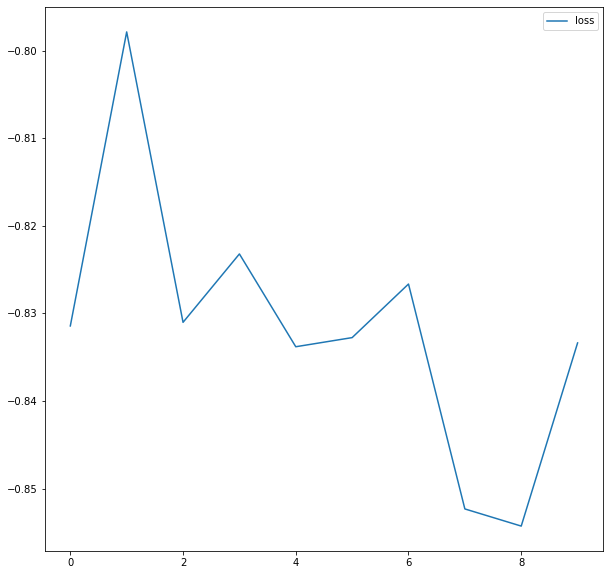

saved model at ./data/NF_jets15/model_9.pth


In [9]:
#####################
### Training Loop ###
#####################

lr=3e-4
weight_decay=1e-5

epochs = 10
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
model.train()

loss_hist = np.array([])

for ep in tqdm(range(epochs)):
    optim.zero_grad()
    
    pbar = tqdm(dataloader)
    for x, c in pbar:
        optim.zero_grad()
        x = x.to(device)
        c = c.to(device)
        
        # Compute loss
        loss = model.forward_kld(x, c)
        
        # Do backprop and optimizer step
        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            optim.step()
        
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

model.eval()

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

torch.save(model.state_dict(), save_dir + f"model_{ep}.pth")
print('saved model at ' + save_dir + f"model_{ep}.pth")

plotting rocs


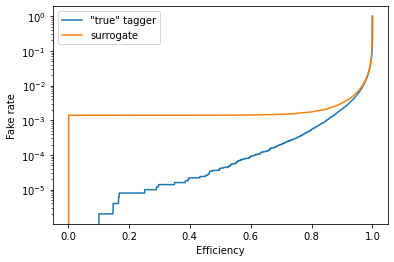

plotting raw (1000000, 1) torch.Size([1000000, 1])
plotting raw gen


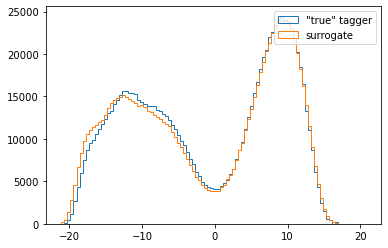

saved images at ./data/NF_jets15/


In [33]:
################
### Plotting ###
################

from sklearn.metrics import roc_curve

with torch.no_grad():
    # get a batch to compare
    conditions = torch.Tensor(dataset_val.features).to(device)
    
    bs = 1000 
    n_bs = len(conditions)//bs+1

    x_gen, _ = model.sample(bs, context=conditions[:bs])
    for i in range(n_bs-1):
        c_data = conditions[(i+1)*bs:(i+2)*bs]
        x_gen_tmp, _ = model.sample(len(c_data), context=c_data)
        x_gen = torch.concat((x_gen, x_gen_tmp), 0)

    x_gen = x_gen*20. #back to full scale
    x_gen_raw = x_gen #HIER SOLLTE NOCH GEMITTELT WERDEN ÜBER OUTPUTS ZUR SELBEN CONDITION
    x_gen = torch.sigmoid(x_gen)
    print("plotting rocs")
    fpr,tpr,_ = roc_curve(dataset_val.truth, dataset_val.raw_target)
    gfpr,gtpr,_ = roc_curve(dataset_val.truth, x_gen.cpu())
    plt.plot(tpr, fpr, label='"true" tagger')
    plt.plot(gtpr, gfpr, label='surrogate')
    plt.xlabel("Efficiency")
    plt.ylabel("Fake rate")
    plt.legend()
    img_outfile = save_dir + f"image_ep{ep}.png"
    plt.savefig(img_outfile)

    plt.yscale('log')
    img_outfile = save_dir + f"image_ep{ep}_log.png"
    plt.savefig(img_outfile)
    plt.show()

    print("plotting raw", dataset_val.target.shape, x_gen_raw.shape)
    _,b,_ = plt.hist(dataset_val.target[:,0]*20.,bins=100, label='"true" tagger',histtype='step')
    print("plotting raw gen")
    plt.hist(x_gen_raw.cpu().numpy()[:,0],bins=b, label='surrogate',histtype='step')
    plt.legend()
    img_outfile = save_dir + f"image_ep{ep}_raw.png"
    plt.savefig(img_outfile)
    plt.show()
    print('saved images at ' + save_dir)